In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from PIL import Image as PILImage
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

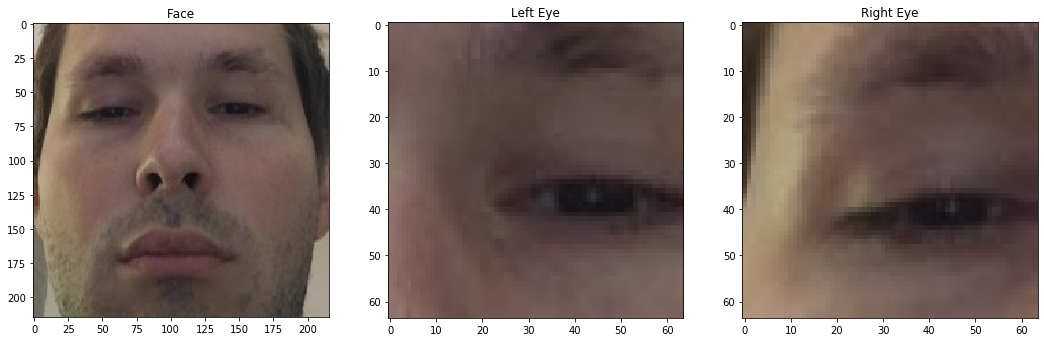

In [27]:
dataset_path = '/data/gc-data-prepped-dlib'
session_path = '00010'
sample_path = '00000'

img_path_face = os.path.join(dataset_path, session_path, "appleFace", sample_path + ".jpg")
img_path_left_eye = os.path.join(dataset_path, session_path, "appleLeftEye", sample_path + ".jpg")
img_path_right_eye = os.path.join(dataset_path, session_path, "appleRightEye", sample_path + ".jpg")

pil_image_face = PILImage.open(img_path_face)
pil_image_left_eye = PILImage.open(img_path_left_eye)
pil_image_right_eye = PILImage.open(img_path_right_eye)


# https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1#file-disp_multiple_images-py
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(np.ceil(n_images/float(cols)), cols, n + 1)
#         if image.ndim == 2:
#             plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
show_images([pil_image_face, pil_image_left_eye, pil_image_right_eye], 
            cols=3,
            titles=["Face", "Left Eye", "Right Eye"])

In [18]:
from ITrackerData import normalize_image_transform
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
color_space = 'YCbCr'
color_space_visualize = 'RGB'

normalize_image = normalize_image_transform(image_size=IMAGE_SIZE, jitter=False, split='test', color_space="RGB")
normalize_image_vis = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

def prepare_image_tensors(color_space, image_face, image_eye_left, image_eye_right, normalize_image, device):
    # Convert to the desired color space
    image_face = image_face.convert(color_space)
    image_eye_left = image_eye_left.convert(color_space)
    image_eye_right = image_eye_right.convert(color_space)

    # normalize the image, results in tensors
    tensor_face = normalize_image(image_face).to(device)
    tensor_eye_left = normalize_image(image_eye_left).to(device)
    tensor_eye_right = normalize_image(image_eye_right).to(device)

    # convert the 3 dimensional array into a 4 dimensional array, making it a batch size of 1
    tensor_face.unsqueeze_(0)
    tensor_eye_left.unsqueeze_(0)
    tensor_eye_right.unsqueeze_(0)

    return tensor_face, tensor_eye_left, tensor_eye_right

tensor_face, tensor_eye_left, tensor_eye_right = prepare_image_tensors(color_space,
                                                                       pil_image_face,
                                                                       pil_image_left_eye,
                                                                       pil_image_right_eye,
                                                                       normalize_image,
                                                                       device)
tensor_face_vis, tensor_eye_left_vis, tensor_eye_right_vis = prepare_image_tensors(color_space_visualize,
                                                                                   pil_image_face,
                                                                                   pil_image_left_eye,
                                                                                   pil_image_right_eye,
                                                                                   normalize_image_vis,
                                                                                   device)

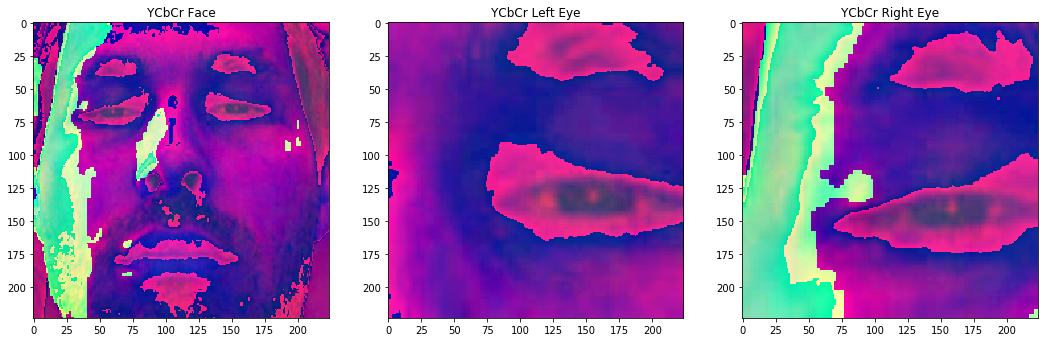

In [19]:
show_images([transforms.ToPILImage()(tensor_face.cpu().squeeze_(0)),
             transforms.ToPILImage()(tensor_eye_left.cpu().squeeze_(0)),
             transforms.ToPILImage()(tensor_eye_right.cpu().squeeze_(0))], 
            cols=3,
            titles=["YCbCr Face", "YCbCr Left Eye", "YCbCr Right Eye"])

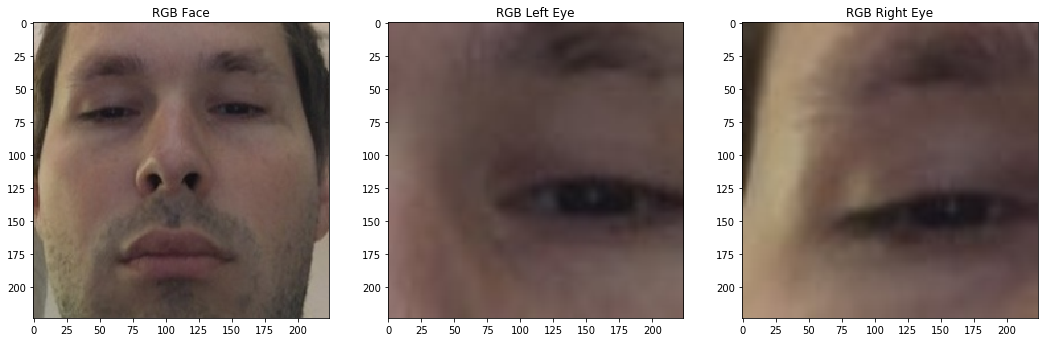

In [20]:
show_images([transforms.ToPILImage()(tensor_face_vis.cpu().squeeze_(0)),
             transforms.ToPILImage()(tensor_eye_left_vis.cpu().squeeze_(0)),
             transforms.ToPILImage()(tensor_eye_right_vis.cpu().squeeze_(0))], 
            cols=3,
            titles=["RGB Face", "RGB Left Eye", "RGB Right Eye"])

In [21]:
from ITrackerModel import ITrackerModel

def initialize_torch(path):
    model = ITrackerModel(color_space).to(device=device)
    saved = torch.load(path, map_location=device)
    model.load_state_dict(saved['state_dict'])
    model.eval()
    return model

model_path = 'checkpoints-ResNET18-YCbCr-unfrozen-dlib/best_checkpoint.pth.tar'
model = initialize_torch(model_path)

faceModel = model.faceModel.conv.model
leftEyeModel = model.eyeModel.model
rightEyeModel = model.eyeModel.model

# model

In [22]:
def compute_gradcam_images(tensor_image, tensor_image_vis, model):
    configs = [
        dict(model_type='resnet', arch=model, layer_name='layer4'),
    ]

    for config in configs:
        config['arch'].to(device).eval()

    cams = [
        [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
        for config in configs
    ]
    
    images = []
    for gradcam, gradcam_pp in cams:
        mask, _ = gradcam(tensor_image)
        heatmap, result = visualize_cam(mask, tensor_image_vis)

        mask_pp, _ = gradcam_pp(tensor_image)
        heatmap_pp, result_pp = visualize_cam(mask_pp, tensor_image_vis)

        images.extend([tensor_image_vis.cpu().squeeze_(0), heatmap, heatmap_pp, result, result_pp])
    
    return images

/home/jatin/.local/lib/python3.7/site-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


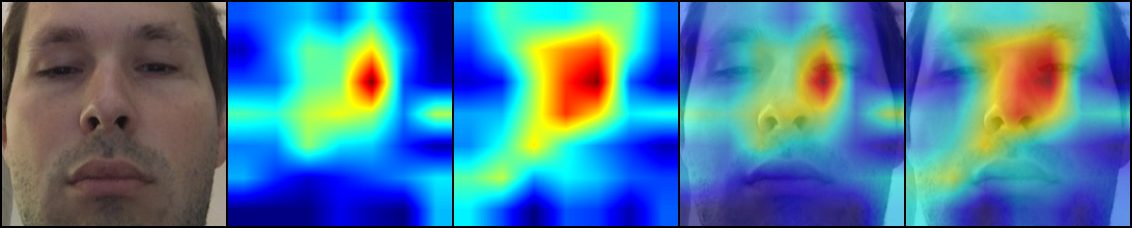

In [23]:
face_images = compute_gradcam_images(tensor_face, tensor_face_vis, faceModel)
grid_face_images = make_grid(face_images, nrow=5)
transforms.ToPILImage()(grid_face_images)

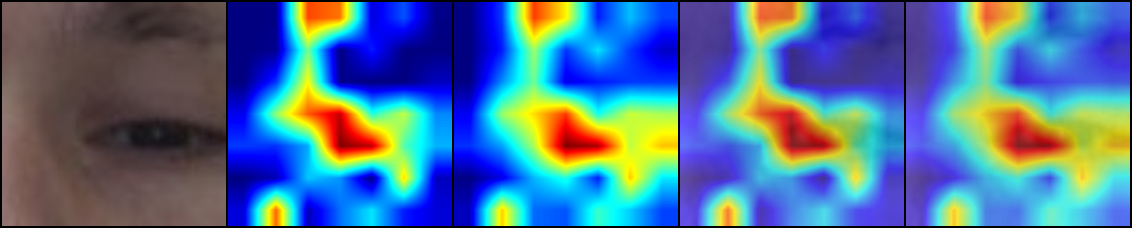

In [24]:
left_eye_images = compute_gradcam_images(tensor_eye_left, tensor_eye_left_vis, leftEyeModel)
grid_left_eye_images = make_grid(left_eye_images, nrow=5)
transforms.ToPILImage()(grid_left_eye_images)

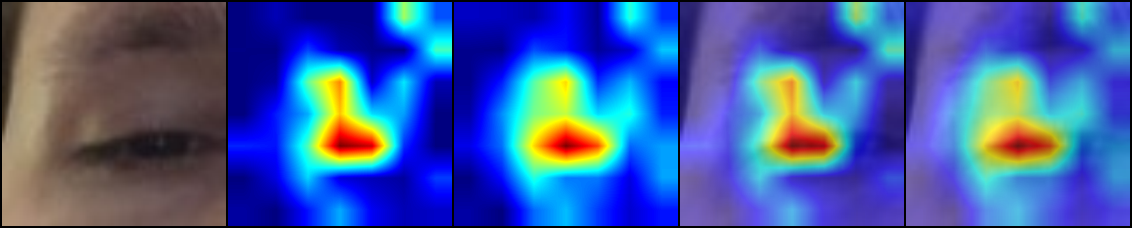

In [28]:
right_eye_images = compute_gradcam_images(tensor_eye_right, tensor_eye_right_vis, rightEyeModel)
grid_right_eye_images = make_grid(right_eye_images, nrow=5)
transforms.ToPILImage()(grid_right_eye_images)